# 🍺 BeerVise: Pick the right beer for you!

Nowadays, drinking beer has become a global social habit, whether it be for parties, football games or meeting with friends. In order to answer this demand, the market has become very attractive and diverse with breweries all around the world producing a wide variety of beer styles. This wide range of offer makes it more difficult for costumers to find a style of beer they might like. Being aware of this issue and with the aim to improve their customers’ satisfaction, an international supermarket chain called upon our data scientists’ team to help better organize their beer shelves. Our strategy is to associate each row of the shelves to a customers’ type. Then, for each of these customers’ categories, the most appreciated styles of beers are promoted with a textual description of their main features. Besides, in order to satisfy the firms’ multidomestic strategy, the arrangement of the beer shelves accounts for a 'nationalist' category wich showcases the best beers of the country we are in. 

# ❓ Research questions 
1. How can beer styles be merged into supra-styles? Which beer styles have features in common and can therefore be grouped (e.g. abv, countries or breweries where they are produced…)?
3. From the reviews, and in order to present a textual description of the beer styles on the shelves, what are the adjectives that best describe each beer supra style?
4. According to which metric can the users be categorised, and how to determine to which categories each user belongs to?
5. Is the taste of a user influenced by his country of origin or his expertise?

In the following notebook we show all the steps done to adress these questions and reach our main objectives.

# Table of Contents
* [Imports](#imports)
* [Data pre-processing](#pre_process)
* [Data loading](#loading)
* [Data exploratory](#exploratory)
* [Merging beer styles into supra-styles](#merge_style)
* [Numerical description of the supra-styles](#num_desc_supra)
* [Textual description of the supra-styles](#text_desc_supra)
* [Categorization of users](#user_categorization)
* [Finding the favorite supra-styles for each category of users](#favorite_supra)
* [Finding the beers to put on the shelves](#beers_shelves)

# Imports <a class="anchor" id="imports"></a>

In [3]:
import warnings
warnings.filterwarnings('ignore')

import re
import math
import copy
import string
import itertools
import pickle
import umap
import pandas as pd
import numpy as np
import fasttext, nltk   # NLP library
import statsmodels.formula.api as smf

import seaborn as sns
import colorcet as cc
import plotly.express as px
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm
from statsmodels.stats import diagnostic

from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(8,6)})
palette = sns.color_palette(cc.glasbey, n_colors=25)

RAW_DATA_FOLDER = 'data/raw/'
PROCESSED_DATA_FOLDER = 'data/processed/'
DATASET = 'BeerAdvocate/'    # Can be either 'BeerAdvocate/' or 'RateBeer/'

## Data pre-processing <a class="anchor" id="pre_process"></a>

For this project two dataset have been provided: data from [BeerAdvocate](https://www.beeradvocate.com) as well as from [RateBeer](https://www.ratebeer.com/) websites.
Both dataset are organized following the same relational model shown bellow.

### ER Diagram:
<img src="figures/ER_diagram.png" alt="ER_Diagram" width="800"/>

### Relations:
<img src="figures/relations.png" alt="relations" width="800"/>

The following analysis will be done on `BeerAdvocate` dataset. Raw data are available [here](https://drive.google.com/drive/folders/1Wz6D2FM25ydFw_-41I9uTwG9uNsN4TCF).
Processed data are available [here](https://drive.switch.ch/index.php/s/QBPV4ptiUoV8XER). In order to reproduce the analysis a data folder with the following architecture should be placed in the root directory of the repository:

<pre>  
├─── data
    ├─── raw
      ├─── BeerAdvocate
        ├─── beers.csv
        ├─── breweries.csv
        ├─── ratings.txt
        ├─── reviews.txt
        ├─── users.csv
      ├─── RateBeer
        ├─── beers.csv
        ├─── breweries.csv
        ├─── ratings.txt
        ├─── reviews.txt
        ├─── users.csv
    ├─── processed
      ├─── BeerAdvocate
        ├─── beers.pkl
        ├─── breweries.pkl
        ├─── ratings.pkl
        ├─── reviews.pkl
        ├─── users.pkl
      ├─── RateBeer
        ├─── beers.pkl
        ├─── breweries.pkl
        ├─── ratings.pkl
        ├─── reviews.pkl
        ├─── users.pkl 
</pre>

If one wants to manually re-produced the processed data from the raw data, simply move to the `src` folder and execute:
```
  python process_raw_data.py
```
Make sure to have all the requirements and that the data in the raw data folder have been uncompressed. Be aware that running the script took around 20 min on Apple silicon M1 Pro. 

## Data loading <a class="anchor" id="loading"></a>

In [4]:
beers = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'beers.pkl')
breweries = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'breweries.pkl')
users = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'users.pkl')
ratings = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'ratings.pkl')
reviews = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'reviews.pkl')


# Make sure there are no duplicates on the primary key
beers.drop_duplicates(subset=['beer_id'], inplace=True)
breweries.drop_duplicates(subset=['id'], inplace=True)
users.drop_duplicates(subset=['user_id'], inplace=True)
ratings.drop_duplicates(subset=['beer_id', 'user_id', 'date'], inplace=True)
reviews.drop_duplicates(subset=['beer_id', 'user_id', 'date'], inplace=True)

## Data exploratory <a class="anchor" id="exploratory"></a>

In this section, we will conduct some basic analyses to get acquainted with the data and some of its features. 

In [5]:
#Taking care of missing values
breweries.replace('UNKNOWN', np.nan, inplace=True)
breweries.dropna(subset='location',inplace=True)

Since we are interested in countries rather that in provinces or states within a country, we make sure to keep only the country as a location.

In [6]:
countries = ["United States","Canada","Utah","England","Wales","Scotland"]

# creates column with corresponding country where  beer is brewed
for country in countries:
    breweries["bool"] = breweries["location"].apply(lambda x: country in x)
    if country == "Utah":
        country = "United States"
    breweries.loc[breweries["bool"], "location"] = country
    del breweries['bool']

A lot of users did not have a location specified.

In [7]:
sum(users.location.isnull())

31279

We drop the users for which no location is provided. 

In [8]:
users.dropna(subset='location',inplace=True)

Once again, we keep only countries.

In [9]:
countries = ["United States","Canada","Utah","England","Wales","Scotland"]

# creates column with corresponding country where  beer is brewed
for country in countries:
    users["bool"] = users["location"].apply(lambda x: country in x)
    if country == "Utah":
        country = "United States"
    users.loc[users["bool"], "location"] = country
    del users['bool']

### Number of breweries per country (descending order)
Let us group the breweries by location.

In [10]:
breweries_country = breweries.groupby('location')
nbr_breweries_by_country = breweries_country.size().sort_values(ascending=False)
nbr_breweries_by_country

location
United States      7434
Germany            1431
England            1029
Canada              860
France              402
                   ... 
Seychelles            1
Macau                 1
Chad                  1
Solomon Islands       1
Senegal               1
Length: 199, dtype: int64

The vast majority of brewers in the dataset are located in the United States. 

### Number of different beers produced per country (descending order)

In [11]:
nbr_beers_by_country = breweries_country['nbr_beers'].agg('sum').sort_values(ascending=False)
nbr_beers_by_country

location
United States        276565
Canada                16993
England                9256
Germany                6180
Belgium                4485
                      ...  
Niger                     1
Dominica                  1
Equatorial Guinea         1
Mali                      0
Gibraltar                 0
Name: nbr_beers, Length: 199, dtype: int64

In a graphical way:

Text(0, 0.5, 'number of beers')

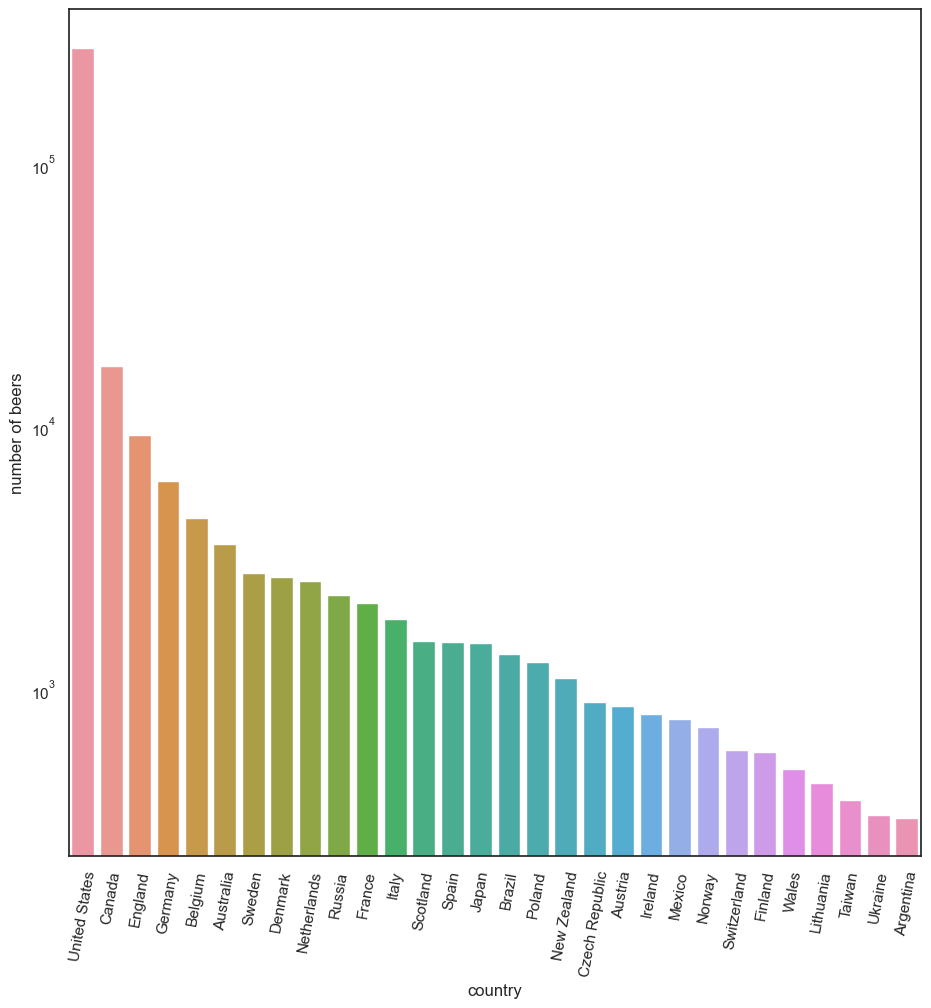

In [12]:
data_dict = {'country': nbr_beers_by_country[:30].index, 'nbr_beer':nbr_beers_by_country[:30].values}

plt.figure(figsize=(11,11))
ax = sns.barplot(x='country', y='nbr_beer', data=data_dict, log=True)
plt.xticks(rotation=80)
plt.xlabel('country')
plt.ylabel('number of beers')

We can observe that the top producing countries (in terms of different beers) are mainly Western countries (USA, Western Europe, Canada, Australia). It is once again largely dominated by the United States.

The first non-Western country is Japan (15th position)

### Number of different beer styles among beers that have been rated, produced in a certain country (descending order)

To determine the number of different beer styles per country, we need for each beer its style which is provided in the beers dataset but we also need the country of production which is not provided. The information of the country can be retrieved from the breweries dataset given that each beer is associated with a brewery and each brewery with a country.

Let us merge the two datasets mentioned above.

In [13]:
beers_merged = pd.merge(beers, breweries, left_on='brewery_id', right_on='id')
beers_merged = beers_merged.drop(columns='id')
beers_merged.head(2)

,beer_id,beer_name,brewery_id,style,avg,abv,avg_computed,location,name,nbr_beers
0,166064,Nashe Moskovskoe,39912,Euro Pale Lager,NaN,4.7,NaN,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,166065,Nashe Pivovskoe,39912,Euro Pale Lager,NaN,3.8,NaN,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5


In [14]:
beers_location_style = beers_merged[['location','style']].groupby('location').nunique()
beers_location_style = beers_location_style['style'].sort_values(ascending=False)
beers_location_style

location
Canada                      103
United States               103
Australia                   101
England                      99
Denmark                      99
                           ... 
Chad                          1
Central African Republic      1
Solomon Islands               1
Gabon                         1
Sao Tome and Principe         1
Name: style, Length: 197, dtype: int64

In [15]:
100*(nbr_beers_by_country['United States'] + nbr_beers_by_country['Canada'])/nbr_beers_by_country.sum()

83.19342972606854

More than 80% of the beers that are rated are produced in the USA or in Canada.

It thus makes sense that a higher number of beer styles are rated for those two countries

### Proportion of different beer styles of rated beers produced in a certain country  (descending order)

We create two dataframes, df and df1. Note that they will be used again later. 

In [16]:
df = beers_merged.groupby('location').size()
df

location
Albania                      15
Algeria                      12
Andorra                       9
Angola                        2
Antigua & Barbuda             2
                           ... 
Virgin Islands (British)      1
Virgin Islands (U.S.)        24
Wales                       493
Zambia                        3
Zimbabwe                     18
Length: 197, dtype: int64

In [17]:
df1 = beers_merged.groupby(['location','style']).size()
df1

location  style                       
Albania   American Amber / Red Lager      1
          American Blonde Ale             1
          Czech Pilsener                  1
          Euro Dark Lager                 1
          Euro Pale Lager                 8
                                         ..
Zimbabwe  English India Pale Ale (IPA)    1
          English Pale Ale                1
          English Stout                   1
          Euro Pale Lager                 6
          Light Lager                     1
Length: 4777, dtype: int64

The proportion of beer styles of beers from a certain country that have been rated can be then obtained easily.
For Albania for exemple:

In [18]:
style_prop_Alb = 100*df1['Albania']/df['Albania']
style_prop_Alb

style
American Amber / Red Lager     6.666667
American Blonde Ale            6.666667
Czech Pilsener                 6.666667
Euro Dark Lager                6.666667
Euro Pale Lager               53.333333
Hefeweizen                     6.666667
Maibock / Helles Bock          6.666667
Märzen / Oktoberfest           6.666667
dtype: float64

Visualized in a pie chart:

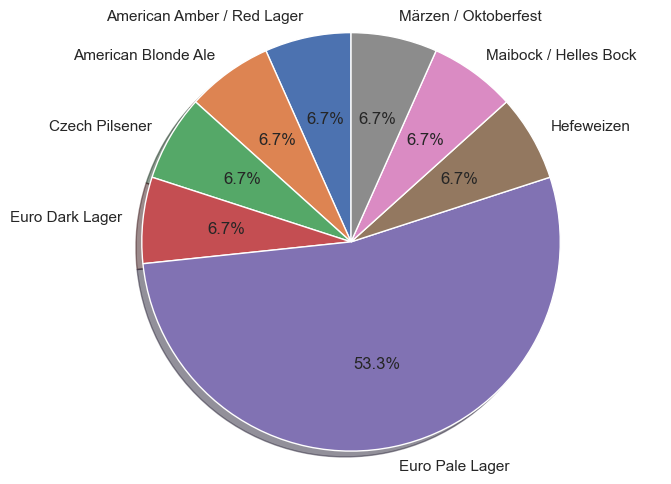

In [19]:
fig1, ax1 = plt.subplots()
ax1.pie(style_prop_Alb.values, labels=style_prop_Alb.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Let us now focus on the users

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122425 entries, 0 to 153703
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   nbr_ratings  122425 non-null  int64  
 1   nbr_reviews  122425 non-null  int64  
 2   user_id      122425 non-null  object 
 3   user_name    122424 non-null  object 
 4   joined       122425 non-null  float64
 5   location     122425 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.5+ MB


### Number of users per country (descending order)

In [21]:
users_country = users.groupby('location')
nbr_users_country = users_country.size().sort_values(ascending=False)
nbr_users_country

location
United States    113223
Canada             3324
England             791
Australia           520
Germany             372
                  ...  
Nicaragua             1
Nigeria               1
Palestine             1
Rwanda                1
Zimbabwe              1
Length: 145, dtype: int64

The users are overwhelmingly Americans.

In a more visual way:

Text(0, 0.5, 'number of users')

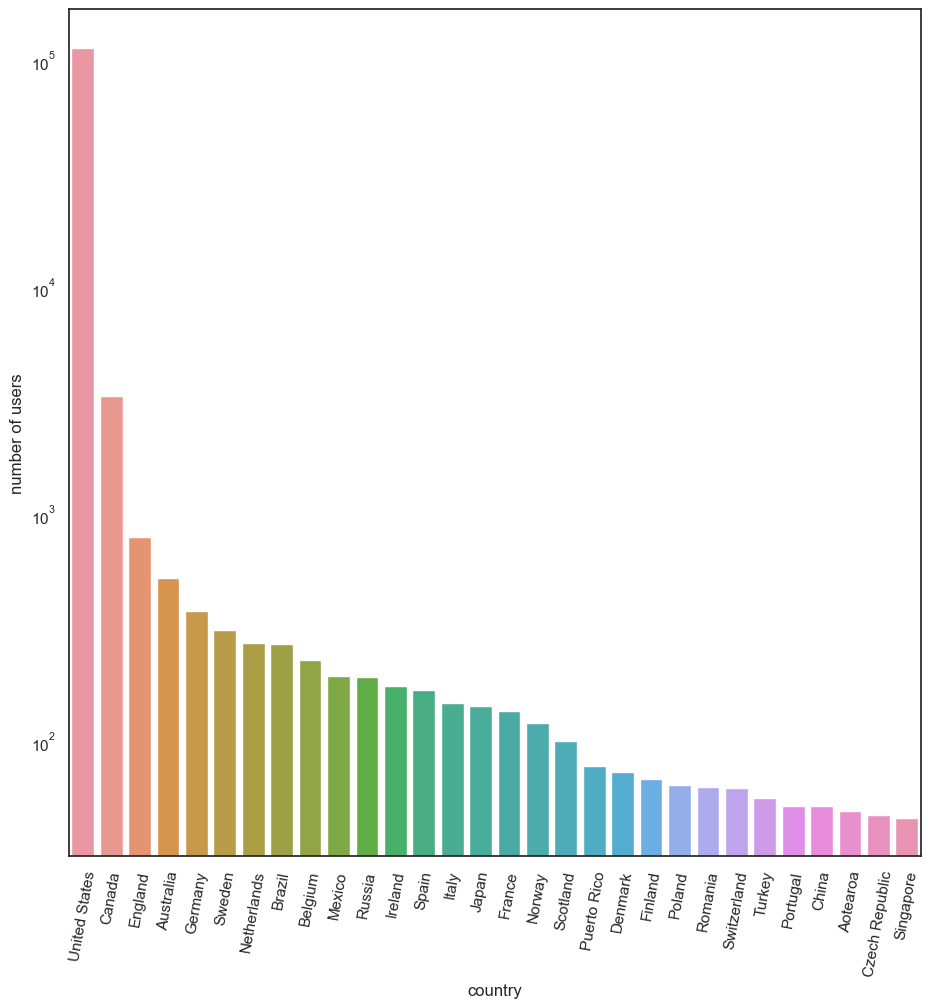

In [22]:
data_dict = {'country': nbr_users_country[:30].index, 'nbr_users':nbr_users_country[:30].values}

plt.figure(figsize=(11,11))
ax = sns.barplot(x='country', y='nbr_users', data=data_dict, log=True)
plt.xticks(rotation=80)
plt.xlabel('country')
plt.ylabel('number of users')

### Number of ratings/review per country (descending order)

In [23]:
nbr_ratings_country = users_country.sum().sort_values(by = 'nbr_ratings', ascending=False)
nbr_ratings_country.head(2)

,nbr_ratings,nbr_reviews,joined
location,,,
United States,7303870,2241334,1.523708e+14
Canada,274512,126591,4.521690e+12


This is no longer a surprise, ratings and reviews are mainly given by people from the United States.

We are going to merge the *ratings* dataframe with the *users* dataframe introduced before to get the location of the user.

In [24]:
ratings_merged= pd.merge(ratings, users, left_on='user_id', right_on='user_id')
ratings_merged.head(2)

,beer_id,date,user_id,appearance,aroma,palate,taste,overall,rating,review,nbr_ratings,nbr_reviews,user_name,joined,location
0,142544,2015-08-20 10:00:00,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,True,7820,465,nmann08,1.199704e+09,United States
1,120824,2015-11-14 11:00:00,nmann08.184925,4.00,3.50,3.75,3.50,3.5,3.56,False,7820,465,nmann08,1.199704e+09,United States


We are now merging our resulting dataframe with the *beers* dataframe to have the information of the beer style, our analysis being based on it.

In [25]:
ratings_merged = pd.merge(ratings_merged, beers, left_on='beer_id', right_on='beer_id')[['style','rating','location']]
ratings_merged.head(2)

,style,rating,location
0,Euro Pale Lager,2.88,United States
1,Extra Special / Strong Bitter (ESB),3.56,United States


### Number of ratings for different beer styles of users from a certain country 

We first create a dataframe grouped by location of user.

In [26]:
ratings_merged_country = ratings_merged.groupby('location')

We also create a dataframe grouped by location of user and style of beer.

In [27]:
ratings_merged_country_style = ratings_merged.groupby(['location','style'])
ratings_merged_country_style.size()

location     style                  
Afghanistan  American Adjunct Lager     1
             American Barleywine        1
             American Porter            1
             Belgian Strong Dark Ale    1
             Czech Pilsener             1
                                       ..
Wales        Vienna Lager               2
             Weizenbock                 2
             Winter Warmer              3
             Witbier                    8
Zimbabwe     English Porter             1
Length: 7049, dtype: int64

### Average ratings of different beer styles given by users from a certain country

In [28]:
ratings_merged_country_style.mean()

rating
location    style                           
Afghanistan American Adjunct Lager   2.00000
            American Barleywine      4.12000
            American Porter          3.51000
            Belgian Strong Dark Ale  4.92000
            Czech Pilsener           1.50000
...                                      ...
Wales       Vienna Lager             4.03000
            Weizenbock               2.34500
            Winter Warmer            3.95000
            Witbier                  3.79375
Zimbabwe    English Porter           4.46000

[7049 rows x 1 columns]

Now we would like to sort these average ratings in descending order to find the beer styles that are the most enjoyed by user of a certain country.

We proceed by creating a dictionary for each country which itself contains a sorted dictionary which takes as a key a beer style and as value a tuple (average rating, number of ratings).

In [29]:
dict_country_style = {}

for key, group in ratings_merged_country_style:
    if key[0] not in dict_country_style:
        dict_country_style[key[0]] = {}
    dict_country_style[key[0]][key[1]] = (np.mean(group['rating']), len(group['rating']))
    
for country in dict_country_style:
    dict_country_style[country] = dict(sorted(dict_country_style[country].items(), key=lambda item: item[1], reverse=True))

For exemple, we have for Spain:

In [30]:
dict_country_style['Spain']

{'Bière de Champagne / Bière Brut': (4.381428571428571, 7),
 'Eisbock': (4.36, 15),
 'Quadrupel (Quad)': (4.343316326530612, 196),
 'Lambic - Unblended': (4.34, 2),
 'Roggenbier': (4.34, 1),
 'American Wild Ale': (4.248333333333334, 30),
 'American Double / Imperial Stout': (4.232105263157895, 171),
 'Russian Imperial Stout': (4.20064039408867, 203),
 'American Strong Ale': (4.193333333333333, 27),
 'American Double / Imperial IPA': (4.129046052631579, 304),
 'Braggot': (4.11, 4),
 'Weizenbock': (4.083333333333334, 69),
 'Flanders Red Ale': (4.080357142857143, 28),
 'Tripel': (4.077188498402555, 313),
 'Belgian Strong Dark Ale': (4.077070063694267, 314),
 'American Barleywine': (4.048518518518518, 27),
 'American Stout': (4.034042553191489, 47),
 'American IPA': (4.002269938650307, 815),
 'Belgian Strong Pale Ale': (3.9872285714285716, 350),
 'American Black Ale': (3.9717000000000002, 100),
 'English Porter': (3.965882352941176, 85),
 'Gueuze': (3.9358064516129034, 31),
 'Baltic Porter

This can be gathered in a dataframe as such:

In [31]:
data_Spain = pd.DataFrame.from_dict(dict_country_style['Spain'], orient = 'index')
data_Spain.columns = ['avg_rating','nbr_rating']
data_Spain['ranked_user'] = np.arange(1,len(data_Spain)+1)
data_Spain.index.name ='style'
data_Spain.head(2)

,avg_rating,nbr_rating,ranked_user
style,,,
Bière de Champagne / Bière Brut,4.381429,7,1
Eisbock,4.360000,15,2


### Summary dataframes for each country

Let us now construct a new dictionary that takes the information contained in dict_country_style that gives for a certain country, the average rating of the different beer styles by people of this country. In addition to this, as was calculated in an earlier part, it also contains the proportion of beers from a certain style produced in a certain country (that have been rated). 

In [32]:
dict_country = {}

for country in ratings_merged.location.unique():

    if country not in df1:
        continue 

    data_country = pd.DataFrame.from_dict(dict_country_style[country], orient = 'index')
    data_country.columns = ['avg_rating','nbr_rating']
    data_country['ranked_user'] = np.arange(1,len(data_country)+1)
    data_country.index.name ='style'

    data_country['%_of_ratings'] = 100*data_country['nbr_rating']/data_country['nbr_rating'].sum()

    y = np.zeros(len(data_country['nbr_rating']), dtype=np.dtype(np.int16))
    y[np.argsort(data_country['nbr_rating'].values)[::-1]] = np.arange(1,len(data_country['nbr_rating'])+1)
    data_country['ranked_nbr_ratings'] = y

    data_country = data_country[['ranked_user', 'avg_rating', 'nbr_rating', '%_of_ratings', 'ranked_nbr_ratings']]#['ranked_user', 'ranked_prod', 'ranked_nbr_ratings', 'avg_rating', 'nbr_rating', '%_of_ratings', 'production_%']]

    dict_country[country] = data_country 

For each country, we now have the information of:
- the beer styles the most liked by the users of this country (ranked_user)
- the beer styles the most rated by the users of this country (ranked_nbr_ratings)

For exemple, for Spain:

In [33]:
dict_country['Spain'].head(2)

,ranked_user,avg_rating,nbr_rating,%_of_ratings,ranked_nbr_ratings
style,,,,,
Bière de Champagne / Bière Brut,1,4.381429,7,0.073031,92
Eisbock,2,4.360000,15,0.156495,86


In [34]:
ratings_merged.loc[ratings_merged.location == 'Spain'].loc[ratings_merged['style']=='Low Alcohol Beer'].rating.mean()

2.0945833333333335

or Australia:

In [35]:
dict_country['Australia'].head(2)

,ranked_user,avg_rating,nbr_rating,%_of_ratings,ranked_nbr_ratings
style,,,,,
Quadrupel (Quad),1,4.164530,362,1.036804,28
Flanders Red Ale,2,4.121679,131,0.375197,70


## Merging beer styles into supra-styles <a class="anchor" id="merge_style"></a>

There is more than one hundred different styles of beers represented in the dataset and we need to find a way to reduce this number cleverly. Indeed keeping those one hundred styles and directly selecting the most liked one among them might result in a poor recommendation as one might end up with near identical beer styles on the shelves. Diversity is key. We need to ensure that costumers will be presented with a sufficiently diversified offer on the shelves hence maximizing the chances that there will find a beer that matches their taste and go home with. 

Discarding styles is not an option but grouping those that have a high similarity can be. We would have all the different styles represented but within supra-styles (a dozen for example) and the ones that are most liked by a category of drinkers will end up on the shelf dedicated to it. Let us try to merge those styles.

The style of the beer is not mentioned in the `ratings` dataframe but in the `beers` dataframe and is needed for the analysis. We hence merge those two dataframes. 

Note: the styles will be analysed based on their similarity of `abv` and of the ratings they got:  `appearance`, `aroma`, `palate`, `taste`, `overall` and `rating`. Those are the features we hence keep in the merge (except the `abv` which we will be added later).

In [36]:
beers_merged = pd.merge(ratings, beers, left_on='beer_id', right_on='beer_id')[['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'style']]
beers_merged.head(2)

,appearance,aroma,palate,taste,overall,rating,style
0,3.25,2.75,3.25,2.75,3.0,2.88,Euro Pale Lager
1,3.00,3.50,3.50,4.00,3.5,3.67,English Pale Ale


In [37]:
print('There are {} different beer styles in the data.'.format(beers_merged['style'].nunique()))

There are 104 different beer styles in the data.


As mentioned before, our analysis should be carried out with a lower number of different beer styles. On the technical side, this will yield stronger statistics. This also serves the overall purpose of our analysis by promoting diversity/variety to customers though a selection of sufficiently different beer styles. Recall that our goal is to design the shelves so as to provide a personal recommendation/selection of the clients likely to be liked by the clients (personal as the client is suggested with beer styles popular among drinkers of his category).

It is easily seen that the proportion of data for the different beer styles differs quite significantly. Some beer styles have only a few beers to represent them and the fear is that those samples do not adequately represent the actual distribution of data in the population. This is an argument for our merge.

In [38]:
beers_merged.groupby('style')['rating'].count().sort_values()

style
Happoshu                               627
Kvass                                  814
Faro                                  1796
Roggenbier                            1911
English Pale Mild Ale                 2443
                                     ...  
Saison / Farmhouse Ale              301953
American Pale Ale (APA)             388139
American Double / Imperial Stout    500265
American Double / Imperial IPA      739982
American IPA                        997814
Name: rating, Length: 104, dtype: int64

Let us jump right in the analysis. For each beer style, we will be considering as features:
- the average alcohol by volume (alcohol content) of all the DIFFERENT beers falling in that style (`abv`)
- the average rating in terms of appearance all the beers falling in that style (`appearance`)					
- the average rating in terms of aroma (`aroma`)
- the average rating in terms of palate (`palate`)
- the average rating in terms of taste (`taste`)
- the average rating in terms of overall impression (`overall`)
- the average rating (`rating`)

Since the `abv` has to be obtained considering each different beer once, we use the `beers` dataset.

We start by grouping by styles and average the 'abv' over each different style.

In [39]:
style_abv = beers.groupby('style').mean()['abv']

Certains styles seems to vary quite a lot in terms of their abv.

In [40]:
style_abv.describe()

count    104.000000
mean       6.422254
std        1.876347
min        1.089788
25%        5.272295
50%        6.048263
75%        7.118561
max       13.945443
Name: abv, dtype: float64

The distribution of the abv for the different styles is plotted below.

Text(0, 0.5, 'Number of beer styles')

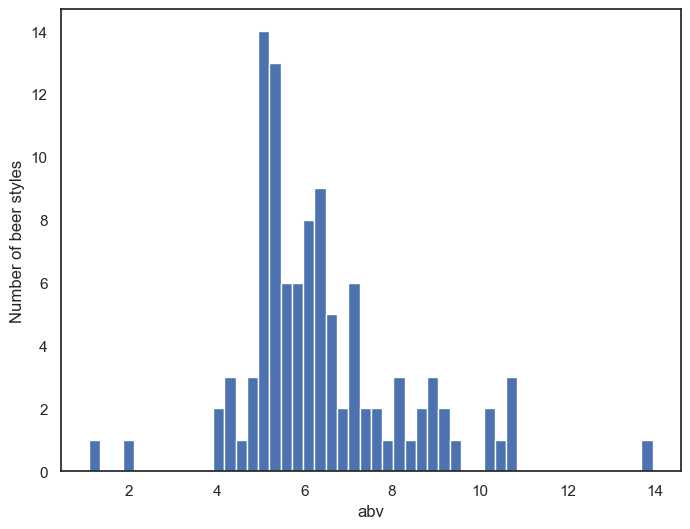

In [41]:
plt.hist(style_abv, bins=50)
plt.xlabel('abv')
plt.ylabel('Number of beer styles')

It appears that the `abv` could potentially be exploited to discrimate styles between one another. 

Back with our `beer_merged` dataframe, we group by styles and average the different ratings over each different style as was done with 'abv'.

In [42]:
style_features = beers_merged.groupby('style').mean()
style_features.head(2)

,appearance,aroma,palate,taste,overall,rating
style,,,,,,
Altbier,3.804970,3.639206,3.712032,3.734094,3.767099,3.688162
American Adjunct Lager,2.834799,2.557520,2.768130,2.722332,2.881181,2.622378


The distribution of those attributes among the population of beer styles is plotted below.

Text(0, 0.6, 'Number of beer styles')

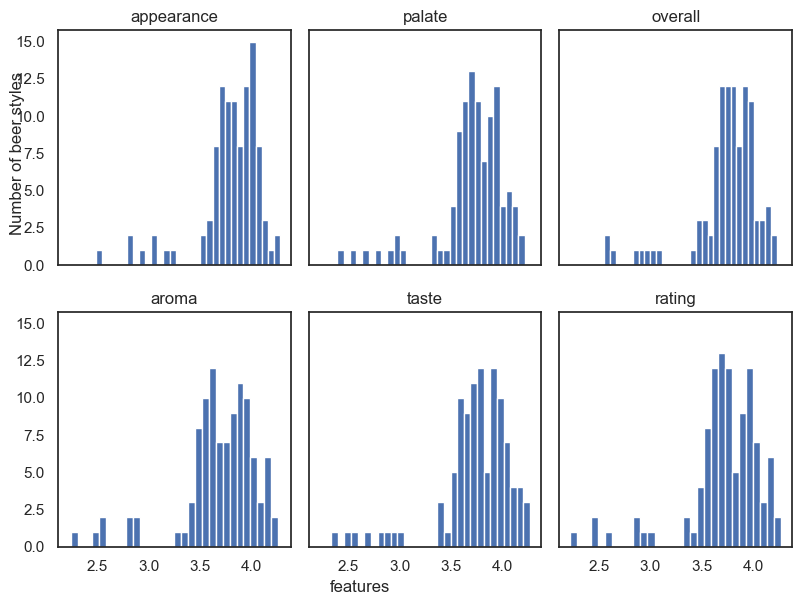

In [43]:
fig, ax = plt.subplots(2,3, sharey = True, sharex = True)

for i in range(6):
    sbplt = ax[i%2, math.floor(i/2)]
    sbplt.hist(style_features.iloc[:,i], bins=30)
    sbplt.set_title(style_features.columns[i])
    
fig.tight_layout()

fig.text(0.4,0, "features")
fig.text(0,0.6, "Number of beer styles", rotation = 90)

There is one additional check that one could perform to see if our enterprise has any chance of succeeding. We can compare the distributions of those 6 attributes for beers belonging to two very different beer styles and see if indeed they differ. If the distribution for two very different beer styles are superimposed, discriminating them solely based on those attributes might be impossible.

Two different beer styles could for example be Pale Ale and Pale Lager. 

In [44]:
Pale_Lager_beer = beers_merged.loc[beers_merged['style'].apply(lambda x: False if x.find('Pale Lager') < 0 else True)].drop(['style'],axis=1)
Pale_Ale_beer = beers_merged.loc[beers_merged['style'].apply(lambda x: False if x.find('Pale Ale') < 0 else True)].drop(['style'],axis=1)

We now plot the normal distributions

In [45]:
def normal(mean, std, sbplt, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = norm.pdf(x, mean, std)
    sbplt.plot(x, p, color, linewidth=2)

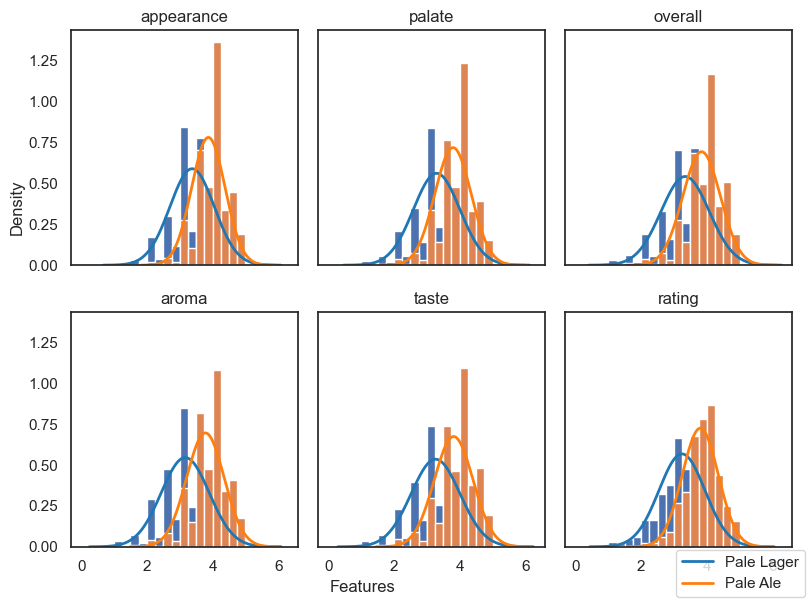

In [46]:
fig, ax = plt.subplots(2,3,figsize= (8,6), sharey = True, sharex = True)

for i,feature in enumerate(style_features.columns):
    sbplt = ax[i%2, math.floor(i/2)]
    sbplt.hist(Pale_Lager_beer[feature], bins=np.arange(0,5.25,0.25), density=True)
    normal(Pale_Lager_beer[feature].mean(), Pale_Lager_beer[feature].std(), sbplt, '#1f77b4')
    sbplt.hist(Pale_Ale_beer[feature], bins=np.arange(0,5.25,0.25), density=True)
    normal(Pale_Ale_beer[feature].mean(), Pale_Ale_beer[feature].std(), sbplt, '#ff7f0e')
    sbplt.set_title(feature)
    
fig.tight_layout()

fig.text(0.4,0, "Features")
fig.text(0,0.6, "Density", rotation = 90)
fig.legend(['Pale Lager','Pale Ale'], loc='lower right')

We see that the distributions are indeed shifted. 
Closing the parenthesis, we can now add back the `abv` feature that was computed using the `beer` dataframe. We also keep track of the names of the different beer styles that will be our labels.

In [47]:
style_features['abv'] = style_abv
style_labels = style_features.index

We convert our features to a numpy array and we standardize them as it is done before PCA to cancel the effect of different variances between features in our initial data.

In [48]:
X = style_features.to_numpy()
X = StandardScaler().fit_transform(style_features.to_numpy())

Now we have all of our features in place, we can perform PCA.

In [57]:
X_reduced_pca = PCA(n_components=2).fit(X).transform(X)

# Plot the data reduced in 2d space with PCA
fig = px.scatter(x=X_reduced_pca[:,0], y=X_reduced_pca[:,1], color=style_labels)
fig.update_layout(
    title='PCA - Beer styles',
    width=1000,
    height=600,
)
fig.show()

Visually, groups are hardly distinguishable.
Considering projections on other PCA components, the results remain quite disappointing. 

In [217]:
pca = PCA()
components = pca.fit_transform(X)
labels_var = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels_var,
    dimensions=range(4),
    color=style_labels,
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    title='PCA - Beer styles',
    width=1000,
    height=600,
)
fig.show()

Note that PCA is an unsupervised linear technique for dimensionality reduction. Some non-linear techniques such as T-SNE or UMAP can further be explored in an attempt to gain further insight. 

Trying out with T-SNE does not yield more meaningful insight.

In [218]:
X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(X)

# Plot the data reduced in 2d space with t-SNE
fig = px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=style_labels)
fig.update_layout(
    title='T-SNE - Beer styles',
    width=1000,
    height=600,
)
fig.show()

In [219]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(X)

fig = px.scatter(x=embedding[:, 0], y=embedding[:, 1], color=style_labels)
fig.update_layout(
    title='UMAP - Beer styles',
    width=1000,
    height=600,
)
fig.show()

Note that there are some groups that start to emerge a bit more distinctly but those results remain hardly exploitable. Some styles that are projected near to one another would not instinctively be considered similar from common-sense knowledge.

Since it is hard to determine them visually, let us now use clustering to try to retrieve some clusters and reason about them.
Note here that an arbitrary number of beer style groups have been selected (16).

In [220]:
# Cluster the data in 16 groups
Klabels = KMeans(n_clusters= 16, random_state=0).fit_predict(X)

This clustering can easily be vizualised thanks to PCA. 

In [221]:
fig = px.scatter(x=X_reduced_pca[:,0], y=X_reduced_pca[:,1], color=Klabels)
fig.update_layout(
    title='K-Means - Beer styles (PCA projections)',
    width=1000,
    height=600,
)
fig.show()

Let us dive a bit more into the different clusters and examine which styles they are made of.

In [222]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = style_features.index.values
cluster_map['cluster'] = Klabels

for i in range(max(Klabels)+1):
    display(cluster_map[cluster_map.cluster == i])

,data_index,cluster
6,American Blonde Ale,0
8,American Dark Wheat Ale,0
16,American Pale Wheat Ale,0
31,Bock,0
35,Cream Ale,0
36,Czech Pilsener,0
38,Dortmunder / Export Lager,0
43,English Bitter,0
45,English Dark Mild Ale,0
46,English India Pale Ale (IPA),0


,data_index,cluster
5,American Black Ale,1
12,American IPA,1
17,American Porter,1
18,American Stout,1
23,Belgian IPA,1
29,Bière de Garde,1
57,Flanders Oud Bruin,1
59,Foreign / Export Stout,1
79,Milk / Sweet Stout,1
83,Oatmeal Stout,1


,data_index,cluster
53,Euro Pale Lager,2
64,Happoshu,2
69,Japanese Rice Lager,2


,data_index,cluster
9,American Double / Imperial IPA,3
11,American Double / Imperial Stout,3
86,Quadrupel (Quad),3
89,Russian Imperial Stout,3


,data_index,cluster
1,American Adjunct Lager,4
13,American Malt Liquor,4


,data_index,cluster
10,American Double / Imperial Pilsner,5
21,Baltic Porter,5
26,Belgian Strong Pale Ale,5
28,Bière de Champagne / Bière Brut,5
37,Doppelbock,5
39,Dubbel,5
94,Scotch Ale / Wee Heavy,5
98,Tripel,5


,data_index,cluster
22,Belgian Dark Ale,6
32,Braggot,6
51,English Strong Ale,6
78,Maibock / Helles Bock,6
85,Pumpkin Ale,6
91,Sahti,6
102,Winter Warmer,6


,data_index,cluster
41,Eisbock,7


,data_index,cluster
4,American Barleywine,8
19,American Strong Ale,8
25,Belgian Strong Dark Ale,8
42,English Barleywine,8
84,Old Ale,8
101,Wheatwine,8


,data_index,cluster
7,American Brown Ale,9
14,American Pale Ale (APA),9
27,Berliner Weissbier,9
49,English Porter,9
50,English Stout,9
62,Gose,9
87,Rauchbier,9
90,Rye Beer,9
97,Smoked Beer,9


,data_index,cluster
3,American Amber / Red Lager,10
15,American Pale Lager,10
30,Black & Tan,10
34,Chile Beer,10
52,Euro Dark Lager,10
60,Fruit / Vegetable Beer,10
72,Kvass,10


,data_index,cluster
54,Euro Strong Lager,11


,data_index,cluster
77,Low Alcohol Beer,12


,data_index,cluster
20,American Wild Ale,13
58,Flanders Red Ale,13
63,Gueuze,13
74,Lambic - Fruit,13
75,Lambic - Unblended,13


,data_index,cluster
0,Altbier,14
2,American Amber / Red Ale,14
24,Belgian Pale Ale,14
33,California Common / Steam Beer,14
40,Dunkelweizen,14
44,English Brown Ale,14
55,Extra Special / Strong Bitter (ESB),14
56,Faro,14
65,Hefeweizen,14
67,Irish Dry Stout,14


,data_index,cluster
76,Light Lager,15


This is not conclusive as the clusters do not really make sense sometimes. 

For some beer styles the results are a bit more encouraging. Among the 8 different stouts, 4 are grouped together in cluster 1 and 2 in cluster 3 for example. Another example is the two Barleywines of the dataset (the American and English Barleywines) that also end up together in cluster 8. But some beer styles such as ales and lagers should be separated and pertain to different categories but fall within the same cluster (e.g 0).  Some beer styles are being grouped together but should not be according to common sense. 

A possible explanation to those poor results is the following: users that have rated those beers might be very different, for example having complete opposite tastes. The analysis would be much more robust considering group of users that share similar understanding and rates in a similar way. Beer styles should be rated in a coherent manner. The problem of identifying group of users is either way part of our datastory and has been done in a coming section. We will get back to this later.

Note that in this process of regrouping styles together we won't start from scratch as our previous results has been quite unsatisfactory. Our earlier analysis has suggested that directly trying to group beer styles in an unsupervised manner (PCA, t-SNE, UMAP, K-Means) based on the features at our disposal (abv and various ratings) was not delivering satisfying results when confronted with accepted knowledge about beer styles. 

As a workaround, we rely on domain experts that have already come up with some beer style categories with similar beer styles (similar in terms of a number of criteria listed by the experts) falling withing the same category. Those groups or "supra-styles" can be found on https://www.craftbeer.com/beer/beer-styles-guide.

The subsequent analysis aims now at validating those groups given our dataset. 15 different "supra-styles" have been identified by the experts (see link above), each one of them comprising several similar beer styles. 

In [223]:
style_features = {}
style_features['Pale Ales'] = ["amber ale", "american pale ale", "english pale ale", "blonde ale", "bitter"]
style_features['Dark Lagers'] = ["amber lager", "dunkel", "marzen", "oktoberfest", "schwarzbier", "vienna lager", "dark lager", "red lager"]
style_features['Brown Ales'] = ["brown ale", "mild"]
style_features['India Pale Ales'] = ["ipa", "indian pale ale"]
style_features['Wheat Beers'] = ["wheat wine ale", "wheat", "witbier", "weisse", "weissbier", "dunkelweizen", "hefeweizen", "kristalweizen"]
style_features['Strong Ales'] = ["barley wine", "barleywine",  "imperial red ale", "barley wine ale", "old ale", "strong ale", "strong pale ale"]
style_features['Belgian Styles'] = ["belgian blonde ale", "dubbel", "belgian strong dark ale", "belgian dark ale", "golden strong ale", "belgian pale ale", "quadrupel", "saison", "tripel"]
style_features['Hybrid Beers'] = ["cream ale", "biere de garde", "bière de garde", "common", "altbier", "kolsch", "kölsch", "red beer", "red ale"]
style_features['Porters'] = ["porter"]
style_features['Stouts'] = ["stout"]
style_features['Bocks'] = ["bock", "doppelbock", "maibock", "weizenbock"]
style_features['Scottish-Style Ales'] = ["heavy", "scottish ale"]
style_features['Wild/Sour Beers'] = ["brett", "sour", "flanders", "lambic", "faro", "gueuze", "gose", "wild"]
style_features['Pilseners and Pale Lagers'] = ["pale lager", "american Lager", "american adjunct lager", "pilsener", "pilsner", "export", "helles"]
style_features['Specialty Beers'] = ["black ale", "barrel-aged", "chocolate", "coffee", "fruit", "field", "craft", "herb", "spice", "honey", "pumpkin", "rye", "roggenbier", "session", "smoke", "rauchbier", "specialty", "sahti"]

In [224]:
beers['supra_style'] = beers['style'].apply(lambda x: x + 'undefined')

for supra_style, features in style_features.items():
    for feature in features:
        beers['supra_style'] = beers['supra_style'].apply(lambda x: supra_style if feature in x.lower() else x)

beers['supra_style'] = beers['supra_style'].apply(lambda x: 'Undefined' if 'undefined' in x.lower() else x)

style_to_supra = {}
for style, groups in beers.groupby('style'):
    style_to_supra[style] = groups.supra_style.iloc[0]

del beers['supra_style']

Let us try now to observe how those newly labelled beer styles (16 "supra-styles") fit with our data when projected using the dimensionality reduction techniques cited above. That would be interesting to see if beer styles that have now been identified as pertaining to one supra-style end up closer compared to styles from other supra-styles. This would come as some sort of validation.

Note that the steps followed are sensibly the same as the previous ones so they will not be commented.

In [225]:
style_features = beers_merged.groupby('style').mean().reset_index()
style_features['supra_style'] = style_features['style'].apply(lambda x: style_to_supra[x])
style_features = style_features.set_index('style')

style_labels = style_features.index
style_labels_merged = style_features.pop("supra_style")

X = StandardScaler().fit_transform(style_features.to_numpy())

X_reduced_pca = PCA(n_components=2).fit(X).transform(X)

pca = PCA()
components = pca.fit_transform(X)
labels_var = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels_var,
    dimensions=range(4),
    color=style_labels_merged,
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    title='PCA - Beer styles',
    width=1000,
    height=600,
)
fig.show()

The results are definitely not optimal but some beer styles within supra-styles do seem to fall closer to each others compared to randomly taken beer styles. Take the stouts (yellow) for example that are "quite" concentrated, or the Strong Ales. 

## Numerical description of the supra-styles <a class="anchor" id="num_desc_supra"></a>

### Analysis of beer styles main production and rating countries

Since the BeerAdvocate dataset contains ratings from users and for beers all around the world, it is interesting to investigate where each beer style is produced and where it is rated. In the following we will analyze where each beer style is mainly produced and rated.

We start by merging `ratings` dataframe with `beer` dataframe to get the style for each beer and the `brewery_id`. We then merge the resulting dataframe with the `breweries` dataset to get the location where the beers are brewed. We finally merge `ratings` with `user` dataset to get user country and number of ratings.

In [226]:
df_merged = ratings.merge(beers[['beer_id','brewery_id','style','abv']], left_on='beer_id', right_on='beer_id')

df_merged = df_merged.merge(breweries[['id','location']], left_on='brewery_id', right_on='id')

# convert dates to datetime
df_merged["date"] = df_merged["date"].apply(pd.to_datetime,unit='s')

# creates column with corresponding country where  beer is brewed
countries = ["United States","Canada","Utah","England","Wales","Scotland"]
df_merged["country"] = df_merged["location"]
for country in countries:
    df_merged["bool"] = df_merged["location"].apply(lambda x: country in x)
    if country == "Utah":
        country = "United States"
    df_merged.loc[df_merged["bool"],"country"] = country
    del df_merged['bool']

# creates column with corresponding user country
users["user_country"] = users["location"]
for country in countries:
    users["bool"] = users[users["location"].notnull()]["location"].apply(lambda x: country in x)
    if country == "Utah":
        country = "United States"
    users.loc[users["bool"] == True,"user_country"] = country
    del users['bool']

users.columns = ["user_nbr_ratings", "user_nbr_reviews", "user_id", "user_name", "date_joined", "location", "user_country"]
df_merged = df_merged[["user_id", "date", "aroma", "palate", "taste", "overall", "rating","abv", "style", "country","beer_id"]].merge(users[['user_nbr_ratings','user_nbr_reviews','user_id','user_country']], left_on='user_id', right_on='user_id')

We can now add the supra styles to the merged dataframe:

In [227]:
df_merged['supra_style'] = df_merged['style'].apply(lambda x: style_to_supra[x])

In the following, we create a dataframe that summarizes for each beer style its `abv` range, the main production country and main rating country.

In [228]:
df_styles = pd.DataFrame(columns=['supra_style','main_style','nb_of_styles', 'main_production_country', 'nbr_production_countries', 'main_rating_country', 'nbr_rating_countries', 'avg_ratings', 'abv_range'])
for style, group in df_merged.groupby(["supra_style"]):
    by_country = {
        'supra_style': [style],
        'main_style': [group["style"].value_counts().keys()[group["style"].value_counts().argmax()]],
        'nb_of_styles': [len(group["style"].unique())],
        'main_production_country': [group["country"].value_counts().keys()[group["country"].value_counts().argmax()]],
        'nbr_production_countries': [len(group["country"].unique())],
        'main_rating_country': [group["user_country"].value_counts().keys()[group["user_country"].value_counts().argmax()]],
        'nbr_rating_countries': [len(group["user_country"].unique())],
        'avg_ratings': [np.nanmean(group["rating"])],
        'abv_range': [[group["abv"].min(), group["abv"].max()]]
    }
    df_styles = pd.concat([df_styles, pd.DataFrame(by_country)], axis=0)

df_styles.reset_index(drop=True, inplace=True)

We notice that the beer styles are all rated and produced mostly in the United States. This might be due to the fact that most users in our dataset are from the United-States and are more likely to rate beers from their own country. 

The best rated supra-style on average is the wild/sour ales style. 

To get an idea on how the production and ratings are distributed for a specific style, we plot the histograms.

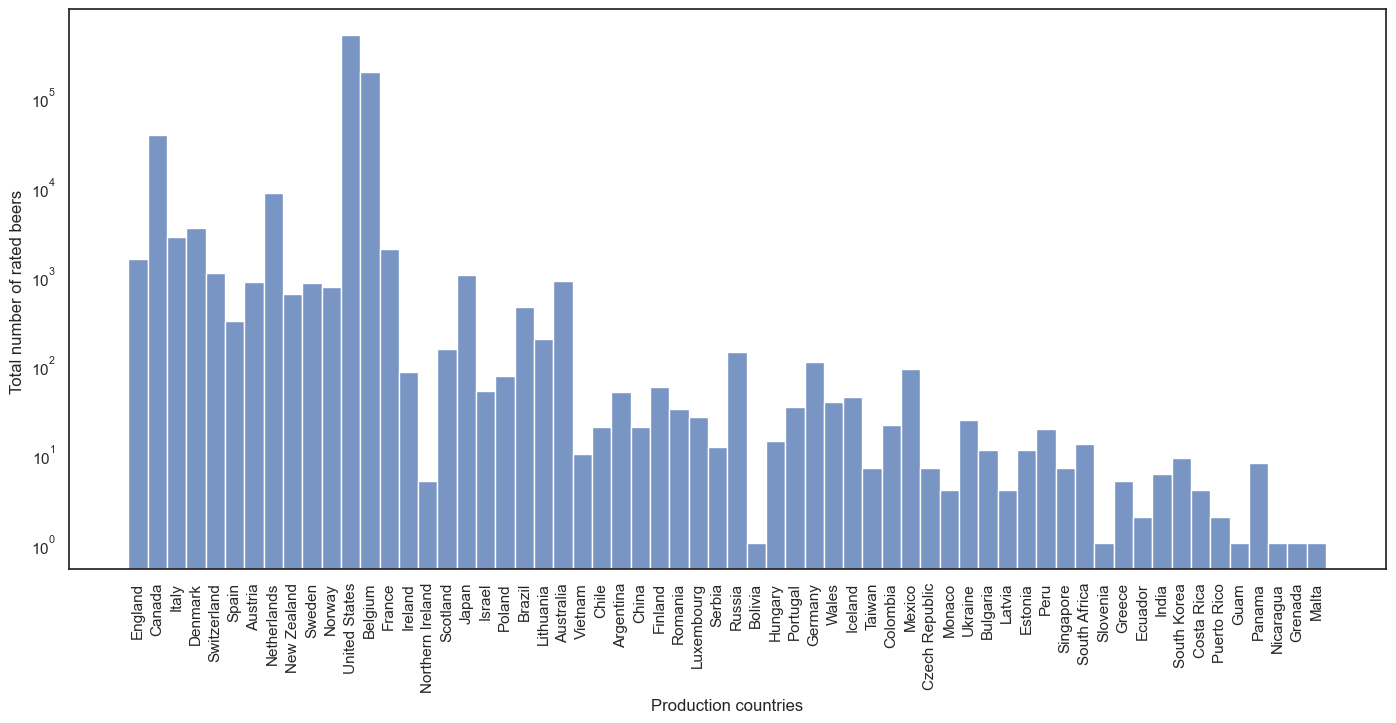

In [229]:
fig, ax = plt.subplots(figsize=(17, 7.27))
sns.histplot(df_merged[df_merged["supra_style"]=="Belgian Styles"].country, ax=ax, bins=len(df_merged[df_merged["supra_style"]=="Belgian Styles"].country.unique()))
ax.set_yscale('log')
ax.set_xlabel('Production countries')
ax.set_ylabel('Total number of rated beers ')
ax.grid(False)
plt.xticks(rotation=90)
plt.show()

In our dataset, the 3 countries that produce the most Belgian styles are the United States, Belgium and Canada. 

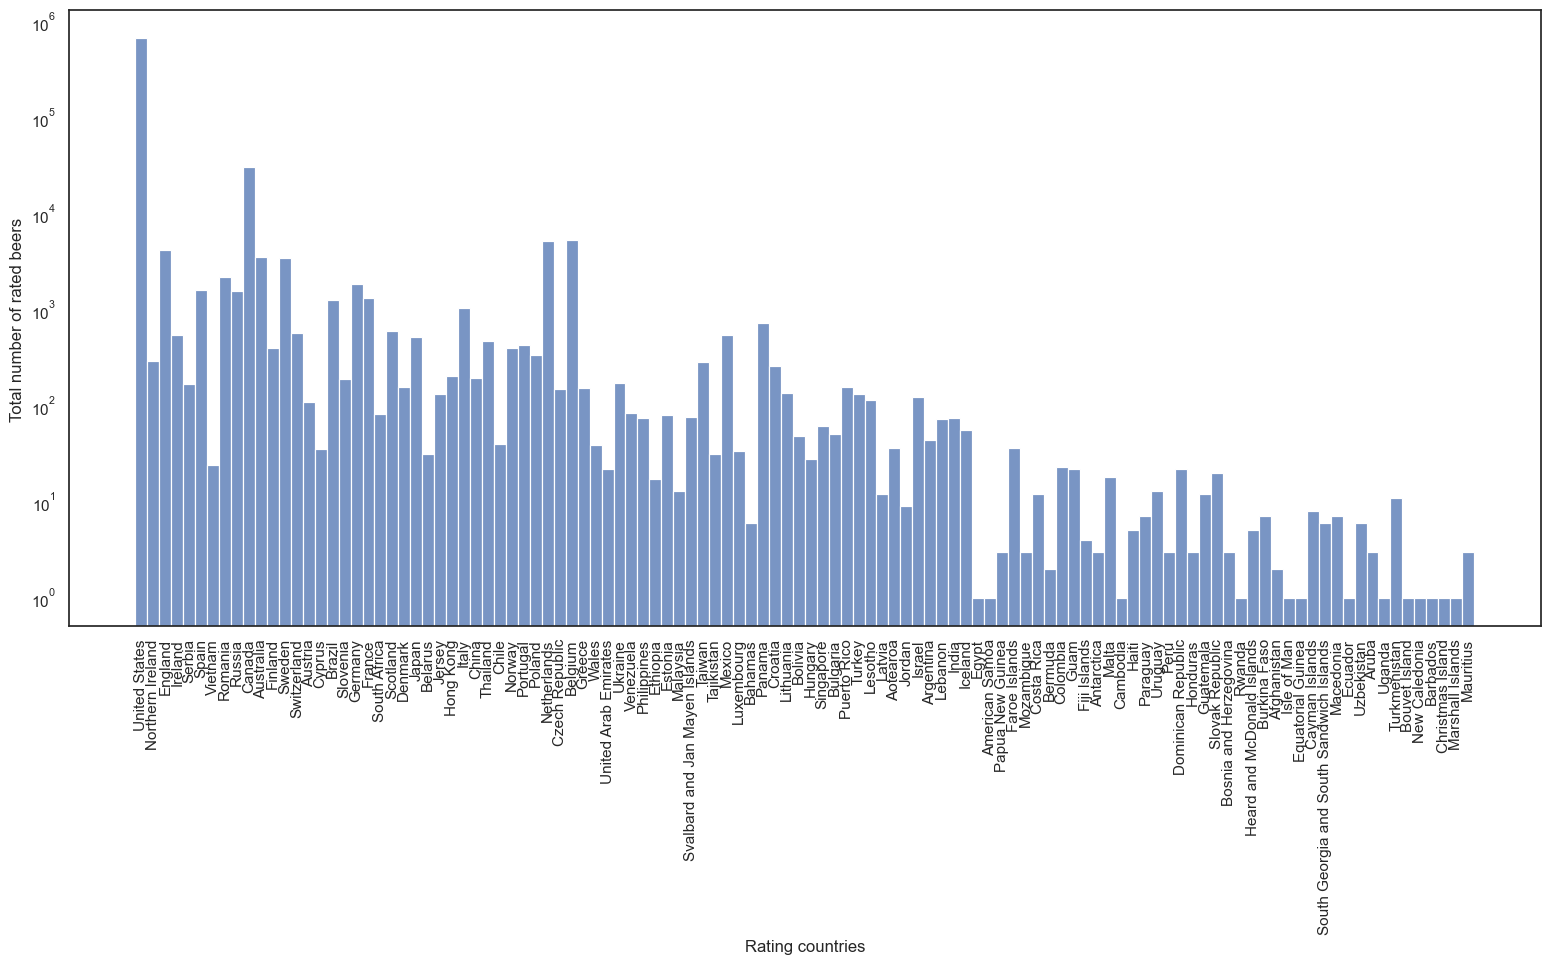

In [230]:
fig, ax = plt.subplots(figsize=(19, 8))
sns.histplot(df_merged[df_merged["supra_style"]=="Belgian Styles"].user_country, ax=ax, bins=len(df_merged[df_merged["supra_style"]=="Belgian Styles"].user_country.unique()))
ax.set_yscale('log')
ax.set_xlabel('Rating countries')
ax.set_ylabel('Total number of rated beers ')
ax.grid(False)
plt.xticks(rotation=90)
plt.show()

In our dataset, the 3 countries that rate the most Belgian styles are the United States, Belgium and Canada. 

### Visualization of the ratings depending on the style

We can also visualize the mean ratings of each supra-style to see if they differ in terms of ratings.

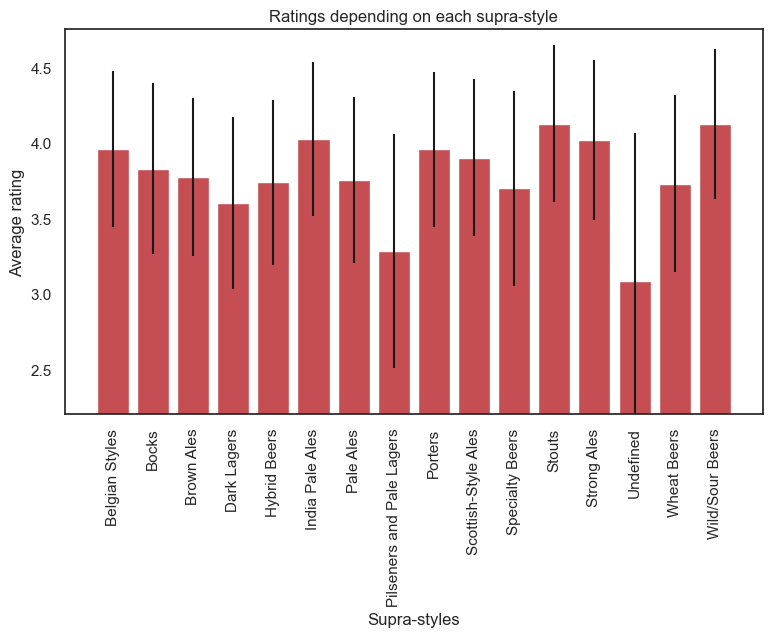

In [231]:
# plot the ratings depending on the style
fig, ax = plt.subplots(figsize=(9, 5))
df_merged["supra_style"] = df_merged["supra_style"]
ax.bar(df_merged.groupby("supra_style")["rating"].mean().keys(),df_merged.groupby("supra_style")["rating"].mean().values,yerr=df_merged.groupby("supra_style")["rating"].std().values,color="r")
ax.set_xlabel('Supra-styles')
ax.set_ylabel('Average rating')
ax.grid(False)
ax.set_title("Ratings depending on each supra-style")
plt.xticks(rotation=90)
plt.ylim([2.2,4.75])
plt.show()

As we can see, the beer style with the highest ratings is the stout style and the one with the lowest ratings is pilsener and pale lager style. 

## Textual description of the supra-styles <a class="anchor" id="text_desc_supra"></a>

In order to help the consumers to choose a beer that would fit their tastes, we try to provide, for each main beer styles, a list of adjectives that best describe the style. 

To determine which adjectives best describe each style, we carry out a lexical analysis based on textual reviews. For a given beer style, the most informatives adjectives are those that occure the most in the textual reviews about the given beer style, but that does not occure to much in reviews of other beer style. To adjust for the fact that some adjectives appear more frequently in general (for example 'good' or 'bad'), we will use a TF-IDF approach, as it is one of the most popular term-weighting schemes today.

This lexical analysis can be decomposed in the following steps:

- Step 1: Group reviews by language.
- Step 2: Group reviews by beer styles.
- Step 3: Extract adjectives from the textual reviews.
- Step 4: Group adjectives by supra style.
- Step 5: Compute the TF-IDF matrix where the documents are the list of adjectives for each supra styles.
- Step 6: Visualize the most informatives adjectives per supra style.

In the following lexical analysis one of the main assumption is that most of the adjectives in the reviews are actually used to describe the beer.

### Step 1: Group reviews by language

To group the reviews by language, a pre-trained language predictor provided by fastText library is used. If one wants to reproduce the following language classification, first make sure to have all the requirements (see requirements.txt in the root of the repository), then download the pre-trained language predictor [here](https://fasttext.cc/docs/en/language-identification.html) and place it in the `/src` folder.

In [232]:
class LanguagePredictor:
    def __init__(self):
        pretrained_lang_model = "src/lid.176.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def predict_lang(self, text):
        predictions = self.model.predict(text)
        language = re.sub(pattern='__label__', repl='', string=predictions[0][0])
        score = predictions[1][0]
        return language, score

In [233]:
model = LanguagePredictor()
reviews['language'] = reviews.text.apply(lambda x: model.predict_lang(x)[0])
reviews['score_language'] = reviews.text.apply(lambda x: model.predict_lang(x)[1])
reviews.head()

,beer_id,user_id,date,text,language,score_language
0,142544,nmann08.184925,2015-08-20 10:00:00,"From a bottle, pours a piss yellow color with ...",en,0.891358
1,19590,stjamesgate.163714,2009-02-20 11:00:00,Pours pale copper with a thin head that quickl...,en,0.924852
2,19590,mdagnew.19527,2006-03-13 11:00:00,"500ml Bottle bought from The Vintage, Antrim.....",en,0.783006
3,19590,helloloser12345.10867,2004-12-01 11:00:00,Serving: 500ml brown bottlePour: Good head wit...,en,0.852789
4,19590,cypressbob.3708,2004-08-30 10:00:00,"500ml bottlePours with a light, slightly hazy ...",en,0.768192


In [234]:
language_count = reviews.groupby('language').text.count().sort_values(ascending=False).rename('Number of reviews')
language_count.head()

language
en    2589044
fr        344
es         64
pt         40
fi         34
Name: Number of reviews, dtype: int64

In [235]:
nb_reviews = len(reviews)
nb_reviews_low_lang_score = len(reviews[reviews.score_language < 0.9])

print("Percentage of reviews with language score bellow 0.9: {:.2f}%".format(100*nb_reviews_low_lang_score/nb_reviews))

Percentage of reviews with language score bellow 0.9: 14.95%


Regarding the number of reviews in each language, the rest of the analysis will be done only on english reviews as there are not enough reviews for other language.

Also, only reviews with a score language (confidence of the sentence belonging to the predicted language) greater or equal than 0.9 are considered. Doing so we throw away less than 15% of the reviews but we make sure to keep only reviews in the same language with high confidence and by the same time we discard dirty reviews (empty reviews, reviews with several languages ...etc..).

In [236]:
LANGUAGE = 'en'
reviews = reviews[(reviews.language == LANGUAGE) & (reviews.score_language >= 0.9)]

### Step 2: Group reviews by beer styles

In order to group the reviews by beer styles we first join the relations `beers` and `reviews` on `beer_id` key, we select `text` and `style` attributes and then we finally group the merged dataframe by `style`. Since the beer styles will be used as name of the files we storing the adjectives, we need to format them (replace `/` and spaces).

In [237]:
merged = reviews.merge(beers, on='beer_id')[['text', 'style']]
merged['style'] = merged['style'].apply(lambda x: x.replace('/', ' ').replace('-', ' '))
merged['style'] = merged['style'].apply(lambda x: ' '.join(x.split()).replace(' ', '_'))
styles = merged['style'].unique()
style_groups = merged.groupby('style')

### Step 3: Extract adjectives from the textual reviews

First the reviews of each beer style are tokenized using the tokenizer provided by `nltk` package. Then the Part-Of-Speech tagger from the same package is applied on each tokenized reviews. The adjectives are the token with the tag `JJ`. Adjectives used in reviews of the same beer style are then stored as a list of string (`adjectives` variable). Since it takes a while to tag the tokens, the intermediate variable `adjectives` is stored in text files for each beer style. This allow the adjectives extraction to be done to be done iteratively, and only once.

In order to improve efficiency punctuations and stopwords are removed before the Part-Of-Speech tagging. Also, caching the stopwords object imported from `nltk` package allow to speed up the process.

Be aware that the following cell is long to run (more than 1h on MacBook M1 Pro). Since the adjectives have already been stored, it is not necessary to run the following cell.

In [238]:
run = False
if run:
    cachedStopWords = stopwords.words("english")

    for style in styles:
        normalized = style_groups.get_group(style).text.str.lower().apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
        tokens = normalized.apply(nltk.word_tokenize).tolist()
        
        for i in range(len(tokens)):
            tokens[i] = [word for word in tokens[i] if word not in cachedStopWords]
        
        tagged_tokens = nltk.pos_tag_sents(tokens)
        adjectives = [word for (word, tag) in list(itertools.chain.from_iterable(tagged_tokens)) if tag == 'JJ']
        
        with open(PROCESSED_DATA_FOLDER + DATASET + 'adjectives/{}.txt'.format(style), 'w') as f:
            f.writelines('\n'.join(adjectives))

### Step 4: Group adjectives by supra style

Given the mapping from beer style to supra beer style computed in the previous sections we can group the adjectives from the same supra beer style. We need to first transform the beer styles to match the format name used to store the adjectives. 

In [239]:
formated_style_to_supra = copy.deepcopy(style_to_supra)

for style, supra_style in style_to_supra.items():
    formated_style = style.replace('/', ' ').replace('-', ' ')
    formated_style = ' '.join(formated_style.split()).replace(' ', '_')
    formated_style_to_supra[formated_style] = style_to_supra[style]
    if style != formated_style:
        del formated_style_to_supra[style]

corpus = {key: [] for key in formated_style_to_supra.values()}
for style in styles:
    with open(PROCESSED_DATA_FOLDER + DATASET + 'adjectives/{}.txt'.format(style), 'r') as f:
        adjectives = f.read().splitlines()
    corpus[formated_style_to_supra[style]].extend(adjectives)

corpus = {key: ' '.join(adjectives) for key, adjectives in corpus.items()}

### Step 5: Compute the TF-IDF matrix

In this step we aim at retrieving the adjectives that are the most informatives for each beer styles. 

As said before, for a given beer style, the most informatives adjectives are those that occure the most in the reviews, but we want to give less importance to the adjectives that frequently appear in every styles. To adjust for the fact that some adjectives appear more frequently in general (for example 'good' or 'bad'), we use a TF-IDF approach, as it is one of the most popular term-weighting schemes today. Here the terms are the adjectives and the documents are the adjectives belonging to the same beer style. 

From [WikiPedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf):
The term frequency (tf) is the relative frequency of term t within document d and it is computed as follow:

$$ \operatorname{tf}(t, d)=\frac{f_{t, d}}{\sum_{t^{\prime} \in d} f_{t^{\prime}, d}} $$

where $f_{t, d}$ is the raw count of a term in a document, i.e., the number of times that term $t$ occurs in document $d$. Note the denominator is simply the total number of terms in document $d$ (counting each occurrence of the same term separately).

One the other hand, the inverse document frequency (idf) is a measure of how much information the word provides, i.e., if it is common or rare across all documents, and it is computed ad follow:

$$ \qquad \operatorname{idf}(t, D)=-\log \frac{n_t}{N} $$

with
- $N$ : total number of documents in the corpus $N=|D|$
- $n_t$ : number of documents where the term $t$ appears (i.e., $\operatorname{tf}(t, d) \neq 0$ ). If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the numerator to $1+n_t$.

Then tf-idf is calculated as
$$
\operatorname{tfidf}(t, d, D)=\operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)
$$
A high weight in tf-idf is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents; the weights hence tend to filter out common terms. Since the ratio inside the idf's log function is always greater than or equal to 1 , the value of idf (and tf-idf) is greater than or equal to 0 . As a term appears in more documents, the ratio inside the logarithm approaches 1 , bringing the idf and tf-idf closer to 0 .

To compute the TF-IDF matrix, `TfidfVectorizer` from `Scikit-Learn` package is used. The `Scikit-Learn` implementation of the TF-IDF matrix is slightly different than the one presented above as the idf term is computed as follow:
$$
\qquad \operatorname{idf}(t, D)=-\log \frac{n_t}{N} + 1
$$
The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents, will not be entirely ignored.

In [240]:
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(list(corpus.values()))

feature_names = vectorizer.get_feature_names()
TF_IDF = pd.DataFrame(X.todense().tolist(), index=list(corpus.keys()), columns=feature_names)

### Step 6: Visualize the most informatives adjectives per supra style

After inpsecting the results it appeared that some irrelevant adjectives still had a high tf-idf terms. This is due to the fact that the implementation of `Scikit-Learn` does not completly ignore the terms that appear in all documents. And here some words appear in all documents and with a very high tf term. Therefore the idf term is not enough to compensate the tf term and it results in a high tf-idf term. We choosed to manually remove those adjectives, and we show the 20 most informatives adjectives (based on the tf-idf weight) as a word cloud where the size of the word are proportional to the associated tf-idf term.

In [241]:
TF_IDF.drop(columns=['good', 'nice', 'bad', 'great'], inplace=True)
TF_IDF.drop(columns=['little', 'big', 'small'], inplace=True)
TF_IDF.drop(columns=['overall', 'much', 'nose'], inplace=True)
TF_IDF.drop(columns=['drinkable', 'decent', 'easy'], inplace=True)

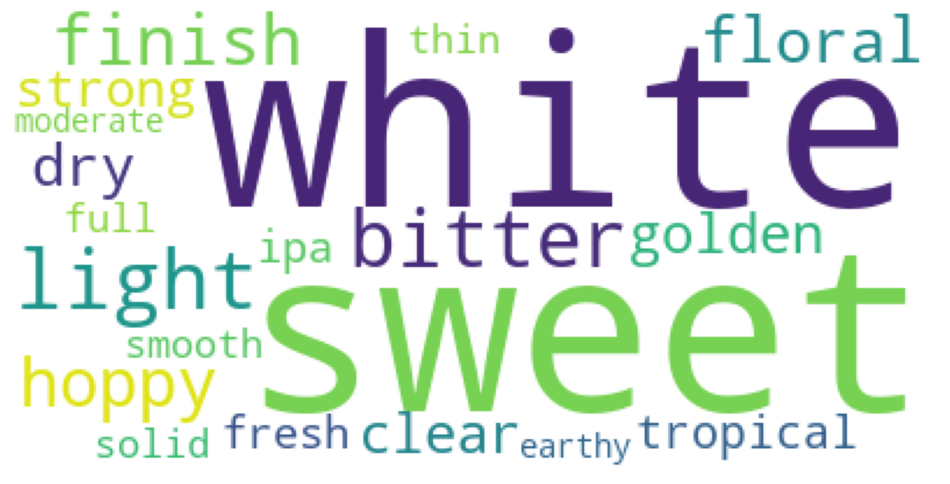

In [249]:
wordcloud = WordCloud(background_color="white", max_words=20).generate_from_frequencies(TF_IDF.loc['India Pale Ales'])

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Categorization of users <a class="anchor" id="user_categorization"></a>

In this part of the analysis, the objective is to categories the users. These categories of users will be the different shelves that each supermaket will have to put in its beers aisle. The different categories that we think can be relevant for the customers are 'experienced beer consumers' which will target the customers which are familiar with beers and consider themselves as regular consumers. 'Novice beer consumers' which on the other hand are rather less accustomed to beer consumption. Another category to showcase is 'explorator beer consumers' which targets all customers which want to try a new kind of beer and want to discover something new. The analysis for this category is based on the users which tend to rate beers that are less popular. Finally, the category 'nationalist' doens't require any processing on the users but will be used to distonguish the supermarket according to their country. It will thus be used to showcase all the beers that are the most popular in the country we are in. 

#### Regression analysis

We have decided to categorize the users based on their country and their experience (based on the number of ratings). The following anaylsis intends to justify these choices by showing that the level of experience of a user and his country of origin influence his preferences in beer styles.

First of all, to get an idea of the user preferences depending on the country of origin and the experience for a user we will conduct a regression analysis predicting the favorite style of a user based on his country of origin and his number of  previous ratings. 

In [250]:
fav_supra_style = df_merged.groupby(['user_id', 'supra_style'])['rating'].mean().groupby(level=0).idxmax().apply(lambda x: x[1])
users['fav_supra_style'] = users.user_id.apply(lambda x: fav_supra_style[x])

one_hot_df = pd.get_dummies(users[["user_country","fav_supra_style","user_nbr_ratings"]])
new_col = pd.DataFrame(np.array(one_hot_df.columns))
new_col[0] = new_col[0].astype("string").apply(lambda x: x.replace(" ", "_"))
one_hot_df.columns = new_col[0].values

Now we can compute a regression that predicts the probability that a given style will be a user favorite depending on the country and the number of ratings of a user. 

For example, we can compute the likelyhood on a scale of 0 to 1 that IPA's are the favorite style for a user coming either from the United states, depending on his number of ratings. 

In [251]:
mod = smf.ols(formula='fav_supra_style_India_Pale_Ales ~ user_nbr_ratings + user_country_United_States',data=one_hot_df)
res = mod.fit()
print(res.summary())

                                   OLS Regression Results                                  
Dep. Variable:     fav_supra_style_India_Pale_Ales   R-squared:                       0.011
Model:                                         OLS   Adj. R-squared:                  0.011
Method:                              Least Squares   F-statistic:                     703.0
Date:                             Thu, 22 Dec 2022   Prob (F-statistic):          2.82e-304
Time:                                     22:05:18   Log-Likelihood:                -63441.
No. Observations:                           122425   AIC:                         1.269e+05
Df Residuals:                               122422   BIC:                         1.269e+05
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
                                 coef    std err          t      P>|t|      [0.0

The intercept is quite high, which indicates that IPA's are a popular style among american users. Moreover the coefficient multiplying the number of users is negative, which implies that the higher the  number of ratings of a user, the less likely his favorite style will be IPA's.

Now to compare the preferences for different beer styles among multiple countries we can plot these regressions for 4 different styles (IPA, Belgian-style ales, Stouts and Pilseners) and 4 countries (United States, Belgium, Canada and Germany) to compare: 

In [252]:
# compute regression for each country and each beer style
countries = ["user_country_United_States", "user_country_Belgium", "user_country_Canada", "user_country_Germany"]
styles = ["fav_supra_style_India_Pale_Ales", "fav_supra_style_Belgian_Styles", "fav_supra_style_Stouts","fav_supra_style_Pilseners_and_Pale_Lagers"]
coefficients = []
for style in styles:
    coefficients_by_country = []
    for country in countries:
        regression_formula = style + ' ~ user_nbr_ratings + ' + country
        mod = smf.ols(formula=regression_formula,data=one_hot_df)
        res = mod.fit()
        coefficients_by_country.append(res.params.values)
    coefficients.append(coefficients_by_country)

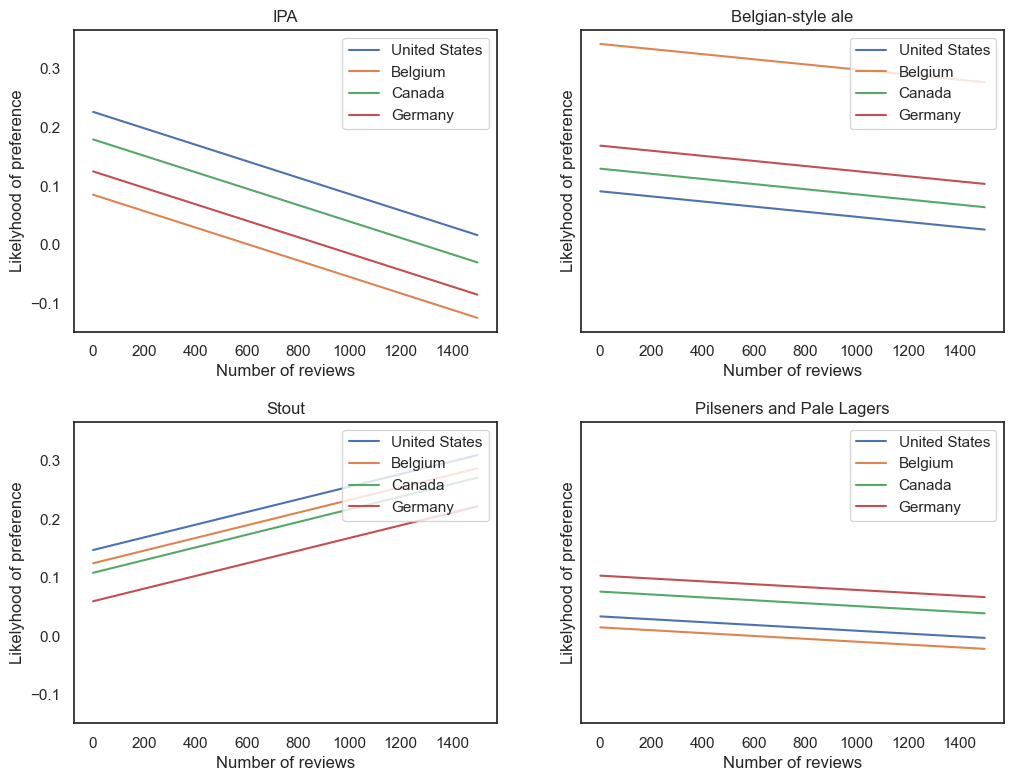

In [253]:
# plot the results
nb_ratings = np.arange(1, 1500)
fig, axes = plt.subplots(2, 2, figsize=(12, 9),sharey=True) 
plt.subplots_adjust(hspace=0.3)
countries = ["United States","Belgium","Canada","Germany"]
styles = ["IPA", "Belgian-style ale", "Stout", "Pilseners and Pale Lagers"]

for i in range(4):
    x,y = [0,0]
    if ((i+1) % 2) == 0: y = 1
    if (i>1): x = 1
    for j in range(4):
        axes[x,y].plot(nb_ratings,coefficients[i][j][0] + coefficients[i][j][1] * nb_ratings + coefficients[i][j][2],label=countries[j])

    axes[x,y].set_title(styles[i])
    axes[x,y].set_xlabel('Number of reviews')
    axes[x,y].set_ylabel('Likelyhood of preference')
    axes[x,y].legend(loc="upper right")

As we can see on the plots above, there is a clear difference of beer style preferences from one country to another. For example, a user from the United States will likely prefer IPA's or Stouts rather than Belgian-style ales. While a user from Belgium will likely prefer Belgian-style ales rather than IPA's. As it was seen before, these differences can be explained by the fact that a user is most likely to rate beers from his own country, thus he will also likely prefer beers produced in his country. In fact, the U-S produce a lot of IPA's and Belgium produces many belgian-style ales. 

### Determine which beers have been rated by each user

In order to categorize the users, we need the information about the users given by the dataset `users`. Similarly, one needs the information about the beers (dataset `beers`) and the ratings of the beers (dataset `ratings`).

Given the fact that a user can rate the same beer at different dates, we don't want to count the number of times a given user rates a given beer but rather how many beers in total a given user rated. Therefore, for each rating we keep the first one if multiple have the same beer_id and user_id.

In [254]:
users = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'users.pkl')
beers = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'beers.pkl')
ratings = pd.read_pickle(PROCESSED_DATA_FOLDER + DATASET + 'ratings.pkl')

users.drop_duplicates(subset=['user_id'], inplace=True)
beers.drop_duplicates(subset=['beer_id'], inplace=True)
ratings.drop_duplicates(subset=['beer_id', 'user_id'], inplace=True)

The information given by each dataset is processed specifically to only draw the usefull elements. Thus,

* Dataset `users`: Used for the users ids, and their level of expertise (number of ratings for each user)
* Dataset `beers`: Used to get the number of ratings of each beer
* Dataset `ratings`: Used to know which beers have been rated and by whom

We now create a dataframe which will gather all the required informlation for further analysis. Thus, for each user, we want how many ratings does he have and which beers did he try.

In [255]:
merged_data = users[['user_id', 'nbr_ratings']]
merged_data = merged_data.merge(ratings[['user_id', 'beer_id']], on='user_id')

### Categorize the users
##### Experienced beer consumers

A user is considered as experienced according to his number of ratings. Indeed, th number of ratings gives an idea about how many beers the user tryied and therefore what is his experience.

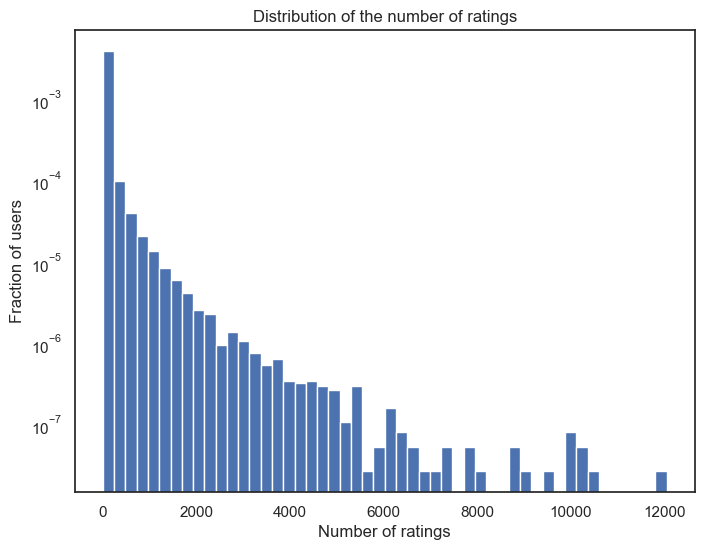

In [256]:
users.nbr_ratings.hist(density=True, bins=50)
plt.yscale('log')
plt.ylabel('Fraction of users')
plt.xlabel('Number of ratings')
plt.title('Distribution of the number of ratings')
plt.grid(False)
plt.show()

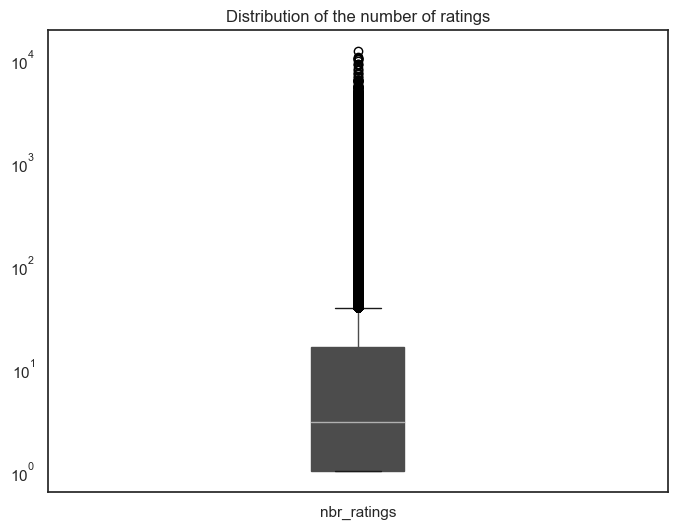

Number of ratings at the different quantiles:


0.00        1.0
0.25        1.0
0.50        3.0
0.75       16.0
1.00    12046.0
Name: nbr_ratings, dtype: float64

In [257]:
users.boxplot(column=['nbr_ratings'], patch_artist=True)
plt.yscale('log')
plt.title('Distribution of the number of ratings')
plt.grid(False)
plt.show()

print('Number of ratings at the different quantiles:')
users.nbr_ratings.quantile([0,0.25,0.5,0.75,1])

In view of the distribution of the number of ratings for the different users, one considers that a user is categorized as an experienced beer consummer if he's considered as outlier when visualizing the ratings distribution using the boxplot. Hence, all users with number of ratings outside 1.5 times the interquartile range above the upper quartile are considered as experienced. Therefore, the experienced threshold is set at Q3 + 1.5 * IQR = Q3 + 1.5 * (Q3-Q1) = 16+1.5 * (16-1) = 39.

In [258]:
print('The experienced beers consumers represent {:.2f}% of the total users in the dataset.'.format(len(users[users.nbr_ratings>39])/len(users) * 100))

The experienced beers consumers represent 15.81% of the total users in the dataset.


#### Novice

Similarly to the experienced users, arbitrarly, an in view of the number of ratings distribution, all users with number of ratings below the median which is set at 3 ratings are considered as novice/beginners.

#### Explorator
A user is considered as explorator if he tends to rate beers that are not that popular. 

In [259]:
ratings_per_beer = ratings.groupby('beer_id')['beer_id'].agg(['count']).reset_index().rename(columns={'count':'nbr_ratings'})

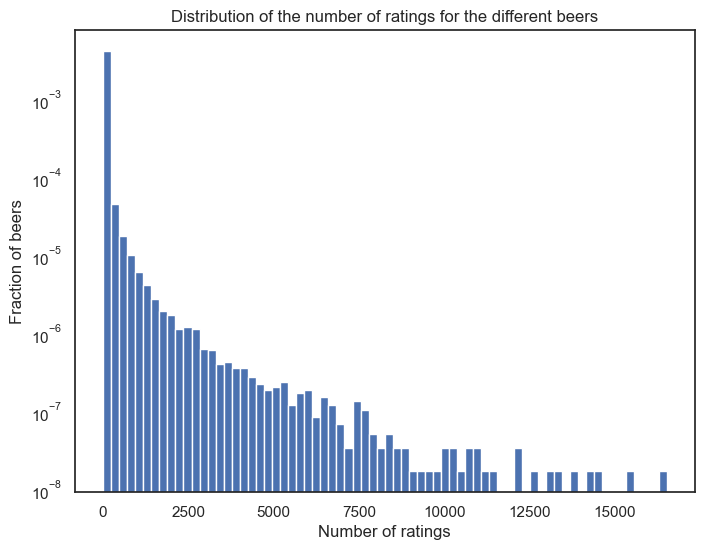

In [260]:
ratings_per_beer.nbr_ratings.hist(density=True, bins=70)
plt.yscale('log')
plt.ylabel('Fraction of beers')
plt.xlabel('Number of ratings')
plt.title('Distribution of the number of ratings for the different beers')
plt.grid(False)
plt.show()

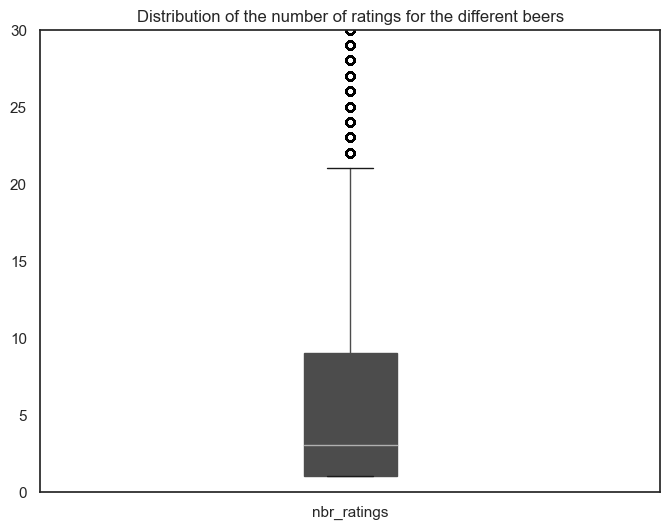

Number of ratings at the different quantiles:


0.00        1.0
0.25        1.0
0.50        3.0
0.75        9.0
1.00    16509.0
Name: nbr_ratings, dtype: float64

In [261]:
ratings_per_beer.boxplot(column=['nbr_ratings'], patch_artist=True)
plt.ylim([0,30])
plt.title('Distribution of the number of ratings for the different beers')
plt.grid(False)
plt.show()

print('Number of ratings at the different quantiles:')
ratings_per_beer['nbr_ratings'].quantile([0,0.25,0.5,0.75,1])

In [262]:
print('The most popular and rated beers represent {:.2f}% of the total number of beers in the dataset.'.format(len(ratings_per_beer[ratings_per_beer.nbr_ratings>21])/len(ratings_per_beer) * 100))
print('{:.2f}% of the total number of beers in the dataset have less than 10 ratings which is negligeable.'.format(len(ratings_per_beer[ratings_per_beer.nbr_ratings<10])/len(ratings_per_beer) * 100))

The most popular and rated beers represent 14.53% of the total number of beers in the dataset.
75.32% of the total number of beers in the dataset have less than 10 ratings which is negligeable.


In view of the distribution of the the number of ratings per beer, one notices the heavy-tail of the distribution. Thus, almost 75% of the beers have less than 10 ratings which is already almost half of the number of ratings than the least popular beer among all the most rated beers. Thereforen a bit arbitrarly, we consider all beers with under 10 ratings as 'scarce beers'. Thus, if a user has rated one of these beers, he's considered as an explorator.

In [263]:
ratings_per_beer['scarce_beer'] =  ratings_per_beer['nbr_ratings'].apply(lambda x: True if x<10 else False)
ratings_per_beer.head(2)

,beer_id,nbr_ratings,scarce_beer
0,3,3,True
1,4,10,False


Once the different categories defined, we can now categories the users.

* Categories users into experienced, novice or none of them directly on the users dataset

In [264]:
users['experienced'] = users['nbr_ratings'].apply(lambda x: True if x>39 else False)
users['novice'] = users['nbr_ratings'].apply(lambda x: True if x<3 else False) 

* Categories users into explorator or not and add this feauture to the the users dataset

In [265]:
merged_data = merged_data.merge(ratings_per_beer[['beer_id', 'scarce_beer']], on='beer_id')
is_explorator = merged_data.groupby('user_id')['scarce_beer'].sum() >= 1 
users['explorator'] = users.user_id.apply(lambda x: is_explorator[x])

In [266]:
users[['user_id', 'user_name', 'experienced', 'novice', 'explorator']]
users.head(2)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,experienced,novice,explorator
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington",True,False,True
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York",True,False,True


## Finding the favorite supra-styles for each category of users <a class="anchor" id="favorite_supra"></a>

Now that we have our user categories, we want to determine which are the favorite styles of users depending on their country and level of experience. For example, we will compare the ratings for each style for different categories of German users. 

In [267]:
df = df_merged.merge(users[['user_id', 'experienced', 'novice', 'explorator']], on='user_id')
df_germany_experienced = df.loc[(df["user_country"]=="Germany") & (df["experienced"]==True)]
df_germany_novice = df.loc[(df["user_country"]=="Germany") & (df["novice"]==True)]

In [268]:
df_g1_mean = df_germany_experienced.groupby("supra_style")["rating"].mean().drop('Brown Ales').sort_index()
df_g1_std = df_germany_experienced.groupby("supra_style")["rating"].std().drop('Brown Ales').sort_index()
df_g2_mean = df_germany_novice.groupby("supra_style")["rating"].mean().sort_index()
df_g2_std = df_germany_novice.groupby("supra_style")["rating"].std().sort_index()

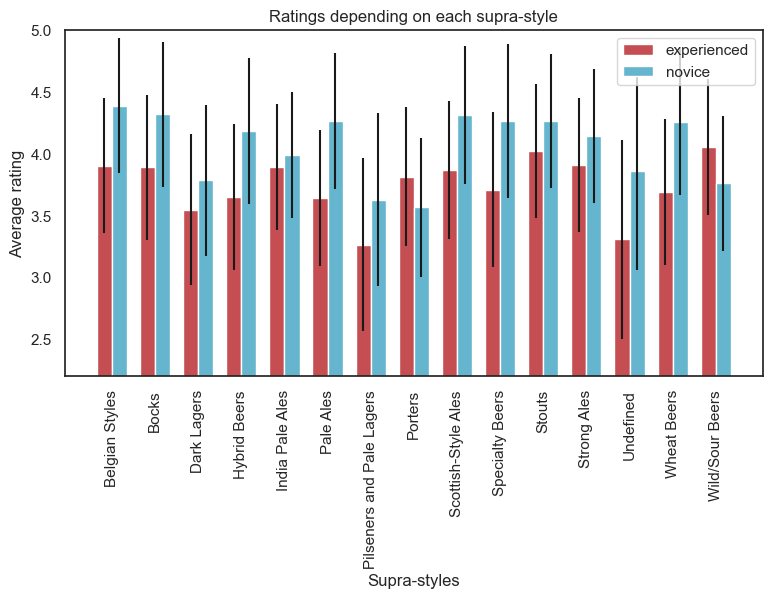

In [269]:
a4_dims = (9, 4.5)
fig, ax = plt.subplots(figsize=a4_dims)
bar_width = 0.35
width = 0.35
index = np.arange(1,16)
ax.bar(index, df_g1_mean.values, yerr=df_g1_std.values,label="experienced", width=width, color='r')
ax.bar(index+bar_width, df_g2_mean.values, yerr=df_g1_std.values,label="novice",width=width, color='c')
ax.set_xlabel('Supra-styles')
ax.set_ylabel('Average rating')
ax.set_xticks(index + width / 2)
ax.set_xticklabels(df_g1_mean.index, rotation=90)
ax.set_title("Ratings depending on each supra-style")
ax.legend()
plt.ylim([2.2,5])
plt.show()

From this plot we see that the 3 favorite beer styles of experienced German users are wild/sour beers, stouts and Strong ales, while for novice German users the favorite beer styles are bocks, Belgian-style ales and Scottish-style ales. 

## Finding the best beers to place on the shelves <a class="anchor" id="beers_shelves"></a>

### Set threshold to minimal number of ratings for a beer

We would like to set a threshold to the minimum number of beers such that we take into account the rating of this beer to find the best beers for each style. In fact, one beer might have been rated only once by a user who gave it a very high rating, but another user might have given it a lower rating, thus this beer should not necessarily be prefered over a beer with slightly lower average rating but with many ratings. As we saw before, the distribution of number of beers is very heavy tailed. The median is at 3 ratings for each beer and the 3rd quantile is at 9 beers. We choose a threshold of a minimal number of 9 ratings for each beer.

To illustrate the procedure of picking the beers to place on the shelves for each category of user, we will take experienced and novice German users and sort out the top 5 beers of their favorite style. It was found previously that the favorite style for experienced users is wild/sour beers and for novice users it is bocks. Thus, we will determine 5 top beers for each category to place on the shelves. 

In [270]:
# get beer id's that have more than 3 ratings
used_beer_ids_1 = df_germany_experienced.groupby('beer_id')['beer_id'].agg(['count']).loc[df_germany_experienced.groupby('beer_id')['beer_id'].agg(['count'])["count"]>=3].reset_index()["beer_id"].values
used_beer_ids_2 = df_germany_novice.groupby('beer_id')['beer_id'].agg(['count']).loc[df_germany_novice.groupby('beer_id')['beer_id'].agg(['count'])["count"]>=3].reset_index()["beer_id"].values

beers_1 = df_germany_experienced.loc[df_germany_experienced["beer_id"].apply(lambda x: x in used_beer_ids_1)]
beers_2 = df_germany_novice.loc[df_germany_novice["beer_id"].apply(lambda x: x in used_beer_ids_2)]

In [271]:
# get average rating for each beer and sort 
mean_ratings_1 = beers_1.groupby('beer_id')['rating'].agg(['mean']).reset_index().sort_values(by="mean",ascending=False).head(5)
mean_ratings_2 = beers_2.groupby('beer_id')['rating'].agg(['mean']).reset_index().sort_values(by="mean",ascending=False).head(5)

In [272]:
# get top 5 beers for experienced german users 
mean_ratings_1.merge(beers[["beer_id","beer_name"]],left_on="beer_id",right_on="beer_id").head(5)

,beer_id,mean,beer_name
0,58299,4.753333,Abner
1,110635,4.747500,Hunahpu's Imperial Stout - Double Barrel Aged
2,6305,4.737500,Drie Fonteinen Oude Geuze
3,61100,4.733333,King Henry
4,41815,4.718889,Parabola


In [273]:
# get top 5 beers for novice german users
mean_ratings_2.merge(beers[["beer_id","beer_name"]],left_on="beer_id",right_on="beer_id").head(5)

,beer_id,mean,beer_name
0,1545,4.878750,Trappist Westvleteren 12 (XII)
1,731,4.668333,Weihenstephaner Hefeweissbier
2,645,4.525000,Trappistes Rochefort 10
3,1774,4.026667,Köstritzer Schwarzbier


The retailer also wants to encourage short food circuits in accordance with current policies and promotes beers made in the country where the store is located. The top shelf will hence be addressed to "patriot" drinkers and consists of local beers that are made in the country.

For each beer we need to have the country where it is produced hence we merge it with the *breweries* dataframe.

In [274]:
beers_merged = pd.merge(beers, breweries, left_on='brewery_id', right_on='id')
beers_merged = beers_merged.drop(columns='id')

We are going to discard beers that have been rated less than 9 times to decrease the bias.

We start by computing the number of ratings per beer and use this information to discard beers. 

In [275]:
ratings_per_beer = ratings.groupby('beer_id')['beer_id'].agg(['count']).reset_index().rename(columns={'count':'nbr_ratings'})
ratings = pd.merge(ratings, ratings_per_beer, left_on='beer_id', right_on='beer_id')
ratings = ratings.loc[ratings.nbr_ratings >= 9]

We now merge the `ratings` dataframe to effectively retrieve the ratings of the beers and be able to select the ones that scored the highest ratings. 

In [276]:
beer_ratings = pd.merge(beers_merged, ratings, left_on='beer_id', right_on='beer_id')[['beer_name','location','rating']]

We create a dictionary which for each country gives the top five highest ranked beers that are made in this country.

In [277]:
fav_beer_per_country = dict()
for country in beers_merged.location.unique():
    beer_country = beer_ratings.loc[beer_ratings.location == country]
    fav_beer_per_country[country] = beer_country.groupby(['beer_name']).mean().sort_values(by='rating', ascending=False)[:5]

For exemple, for Spain, those 5 beers are:

In [278]:
fav_beer_per_country['Spain']

,rating
beer_name,
4B Oude Gueuze,4.309000
Moose Islay,4.228571
Aotearoa,4.204545
Mala Vida Bourbon,4.202222
Dougall's 942 IPA,4.180000


For France:

In [279]:
fav_beer_per_country['France']

,rating
beer_name,
Dalva Millésime,4.232222
Saint Rieul Triple,4.217895
L'Amalthée,4.115370
Cuvée Des Jonquilles,4.110884
Fleurac La Triple Brune IPA,4.100909


For Switzerland:

In [280]:
fav_beer_per_country['Switzerland']

,rating
beer_name,
XV (√225 Saison) - Zymatore,4.358889
Abbaye De Saint Bon-Chien Zymatore (Aged In Hill Rock Rye Whiskey Barrels),4.337333
"Abbaye De Saint Bon-Chien 2011 (Merlot, Cabernet, Whiskey, Grappa Barrels)",4.321724
Abbaye De Saint Bon-Chien,4.321713
Abbaye De Saint Bon-Chien Pommeau - Zymatore,4.308125
